In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pyrex
import pyrex.custom.ara as ara
from pyrex.internal_functions import normalize
import os

import seaborn as sns

# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

current_palette = sns.color_palette('colorblind', 10)

In [2]:
hpol = ara.HpolAntenna("HPol", (0, 0, -200), 0)
hpol.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))

Text(0,0.5,'Heff [m]')

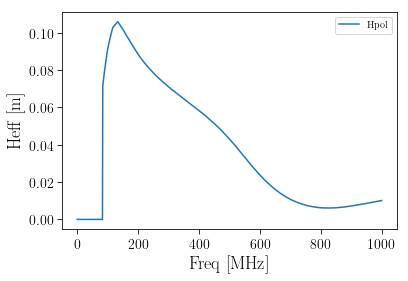

In [3]:
theta = np.pi/2
phi = 0
freqs = np.linspace(0,1,1001)
hpol_pol = np.array([-np.sin(phi),np.cos(phi),-1/np.sin(theta)])
vpol_pol = np.array([-np.sin(phi),np.cos(phi),-1/np.sin(theta)])
# vpolResp = vpol.antenna.directional_response(theta,phi, vpol_pol)(freqs*1E9)*vpol.antenna.frequency_response(freqs*1E9)
hpolResp = hpol.antenna.directional_response(theta,phi, hpol_pol)(freqs*1E9)*hpol.antenna.frequency_response(freqs*1E9)
# plt.plot(freqs*1000,abs(vpolResp),label="Vpol")
plt.plot(freqs*1000,abs(hpolResp), label="Hpol")
plt.legend()
plt.xlabel("Freq [MHz]")
plt.ylabel("Heff [m]")

In [7]:
ARASIM_VPOL_DATA_FILE = os.path.join(pyrex.custom.ara.antenna.ARA_DATA_DIR,
                                     "ARA_bicone6in_output.txt")
ARASIM_HPOL_DATA_FILE = os.path.join(pyrex.custom.ara.antenna.ARA_DATA_DIR,
                                     "ARA_dipoletest1_output.txt")
# Vpol data file contains only the theta responses
ARASIM_VPOL_THETA_RESPONSE_DATA = pyrex.custom.ara.antenna._read_arasim_antenna_pickle(ARASIM_VPOL_DATA_FILE)
ARASIM_VPOL_RESPONSE_DATA = (
    ARASIM_VPOL_THETA_RESPONSE_DATA[0],
    np.zeros(ARASIM_VPOL_THETA_RESPONSE_DATA[0].shape),
    *ARASIM_VPOL_THETA_RESPONSE_DATA[1:]
)
# Hpol data file contains only the phi responses
ARASIM_HPOL_PHI_RESPONSE_DATA = pyrex.custom.ara.antenna._read_arasim_antenna_pickle(ARASIM_HPOL_DATA_FILE)
ARASIM_HPOL_RESPONSE_DATA = (
    np.zeros(ARASIM_HPOL_PHI_RESPONSE_DATA[0].shape),
    *ARASIM_HPOL_PHI_RESPONSE_DATA
)

In [8]:
class AraSimHpol(pyrex.custom.ara.antenna.ARAAntennaSystem):
    def __init__(self, name, position, power_threshold,
                 amplification=1, amplifier_clipping=1, noisy=True,
                 unique_noise_waveforms=10):
        super().__init__(response_data=ARASIM_HPOL_RESPONSE_DATA,
                         name=name, position=position,
                         power_threshold=power_threshold,
                         orientation=(0,0,1),
                         amplification=amplification,
                         amplifier_clipping=amplifier_clipping,
                         noisy=noisy,
                         unique_noise_waveforms=unique_noise_waveforms)

In [9]:
hpolARA = AraSimHpol("HPol", (0, 0, -200), 0)

In [10]:
freq_resp_H = hpolARA.antenna.frequency_response(freqs*1E9)*hpolARA.antenna.directional_response(np.pi/2, phi, hpol_pol)(freqs*1E9)
freq_resp_Ch_H = hpol.antenna.frequency_response(freqs*1E9)*hpol.antenna.directional_response(np.pi/2, phi, hpol_pol)(freqs*1E9)

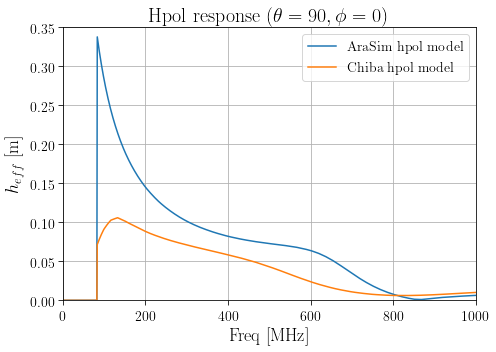

In [91]:
plt.figure(figsize=(7,5))
plt.plot(freqs*1000, abs(freq_resp_H), label = "AraSim hpol model")
plt.plot(freqs*1000, abs(freq_resp_Ch_H), label = "Chiba hpol model")
plt.ylim(0,0.35)
plt.ylabel("$h_{eff}$ [m]")
plt.xlabel("Freq [MHz]")
plt.title("Hpol response ($\\theta = 90, \phi=0$)")
plt.grid()
plt.xlim(0,1000)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("./plots/Antennas/Hpol_boresight_response.pdf")

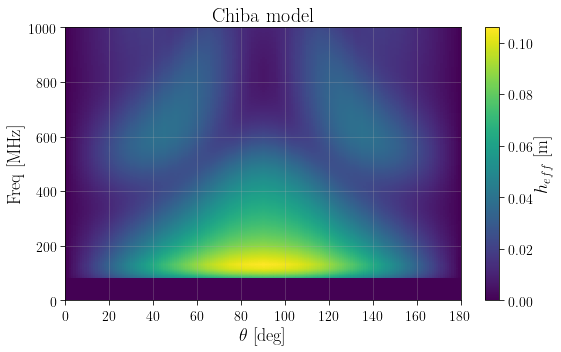

In [4]:
plt.figure(figsize=(8,5))
thetas = np.linspace(0, 180, 181)

X, Y = np.meshgrid(thetas, freqs)
hpol_resp = [hpol.antenna.directional_response(theta, phi, hpol_pol)(freqs*1E9)*hpol.antenna.frequency_response(freqs*1E9) for theta in np.radians(thetas)]
cmap=plt.pcolormesh(X.T, 1000*Y.T, abs(np.array(hpol_resp)),shading='gouring',rasterized=True)
plt.colorbar(cmap,label='$h_{eff}$ [m]')
plt.ylim(0,1000)
plt.xlim(0,180)
plt.ylabel("Freq [MHz]")
plt.xlabel("$\\theta$ [deg]")
plt.grid(alpha=0.3)
plt.title("Chiba model")
plt.tight_layout()
# plt.savefig("./plots/Antennas/ChibaHpol_zenith_response.pdf")

In [8]:
np.shape(hpol_resp)

(181, 1001)

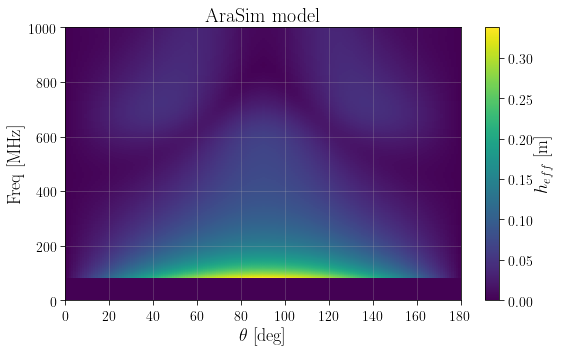

In [98]:
plt.figure(figsize=(8,5))
thetas = np.linspace(0, 180, 181)

X, Y = np.meshgrid(thetas, freqs)
hpol_resp = [hpolARA.antenna.directional_response(theta, phi, hpol_pol)(freqs*1E9)*hpolARA.antenna.frequency_response(freqs*1E9) for theta in np.radians(thetas)]
cmap=plt.pcolormesh(X.T, 1000*Y.T, abs(np.array(hpol_resp)),shading='gouring',rasterized=True)
plt.colorbar(cmap,label='$h_{eff}$ [m]', )
plt.ylim(0,1000)
plt.xlim(0,180)
plt.ylabel("Freq [MHz]")
plt.xlabel("$\\theta$ [deg]")
plt.grid(alpha=0.3)
plt.title("AraSim model")
plt.tight_layout()
plt.savefig("./plots/Antennas/AraSimHpol_zenith_response.pdf")


# Effective volume

In [2]:
colName=["Energy", "Aeff", "Err", "Nthrown", "Npassed", "weight_thrown", "Veff","Err_Veff"]

In [3]:
default = pd.read_csv("/users/PCON0003/cond0068/ARA/AraSim/veffs/Veff_default.txt", names=colName)
default=default.sort_values(by='Energy')
default=default.reset_index()
default = default.drop("index",axis=1)
energies2 = 10**np.array([17.0,18.0, 19.0, 20.0, 21.0])

Chiba = pd.read_csv("/users/PCON0003/cond0068/ARA/AraSim/veffs/Veff_Chiba_antModel.txt", names=colName)
Chiba=Chiba.sort_values(by='Energy')
Chiba=Chiba.reset_index()
Chiba = Chiba.drop("index",axis=1)

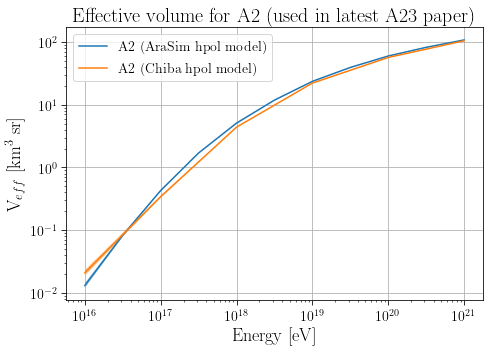

In [12]:
plt.figure(figsize=(7,5))

plt.plot(default.Energy, default.Veff, label = "A2 (AraSim hpol model)")
plt.fill_between(default.Energy, default.Veff-default.Err_Veff, default.Veff+default.Err_Veff, alpha=0.5)
plt.plot(Chiba.Energy, Chiba.Veff, label = "A2 (Chiba hpol model)")
plt.fill_between(Chiba.Energy, Chiba.Veff-Chiba.Err_Veff, Chiba.Veff+Chiba.Err_Veff, alpha=0.5)


plt.yscale('log')
plt.xscale('log')
plt.title("Effective volume for A2 (used in latest A23 paper)")
plt.xlabel("Energy [eV]")
plt.ylabel("V$_{eff}$ [km$^3$ sr]")
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig("./plots/Antennas/Veff_comparisonChibavsAraSim.pdf")

In [5]:
default_E = np.array(default.Energy[0::2])
default_Veff = np.array(default.Veff[0::2])
default_err = np.array(default.Err_Veff[0::2])

In [6]:
# default_Veff.reset_index()
# default_Veff.drop("index",axis=0)
np.array(default_Veff)

array([1.310226e-02, 4.289852e-01, 5.100196e+00, 2.362973e+01,
       5.997160e+01, 1.082098e+02])

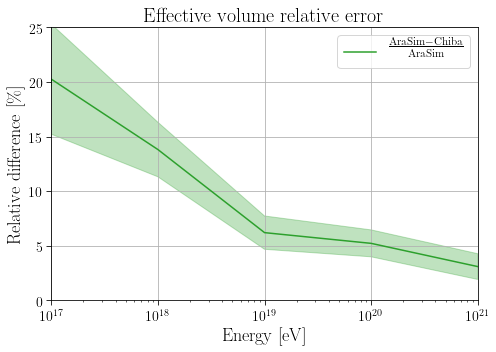

In [13]:
plt.figure(figsize=(7,5))

# ratio = (askaryan_up["Aeff"]-default["Aeff"])/default["Aeff"]
ratio = 100*(default_Veff-Chiba.Veff)/default_Veff
# err_ratio = 100*np.sqrt((veffs_pyrex_new_err/default.Veff[:-1])**2+(veffs_pyrex_new*default.Err_Veff[:-1]/default.Veff[:-1]**2)**2)
err_ratio = 100*np.sqrt((default_err/Chiba.Veff)**2+(default_Veff*Chiba.Err_Veff/Chiba.Veff**2)**2)


plt.plot(default_E, ratio, color="C2", label = "$\\frac{\mathrm{AraSim-Chiba}}{\mathrm{AraSim}}$")
plt.fill_between(default_E,ratio-err_ratio,ratio+err_ratio, color="C2", alpha=0.3)

# plt.yscale('log')
plt.xscale('log')
plt.title("Effective volume relative error")
plt.xlabel("Energy [eV]")
plt.ylabel("Relative difference [\%]")
plt.legend(fontsize=16)
plt.grid()
plt.xlim(1E17,1E21)
plt.ylim(0,25)
plt.tight_layout()

plt.savefig("./plots/Antennas/relDiff_comparisonChibavsAraSim.pdf")


## Effective volume per trigger

In [5]:
colName=["Energy", "Aeff", "Err", "Nthrown", "Npassed", "weight_thrown", "Veff","Err_Veff", "VeffVpol", "VeffHpol"]

In [6]:
default = pd.read_csv("/users/PCON0003/cond0068/ARA/AraSim/veffs/Veff_default_trigger.txt", names=colName)
default=default.sort_values(by='Energy')
default=default.reset_index()
default = default.drop("index",axis=1)

Chiba = pd.read_csv("/users/PCON0003/cond0068/ARA/AraSim/veffs/Veff_Chiba_antModel_trigger.txt", names=colName)
Chiba=Chiba.sort_values(by='Energy')
Chiba=Chiba.reset_index()
Chiba = Chiba.drop("index",axis=1)

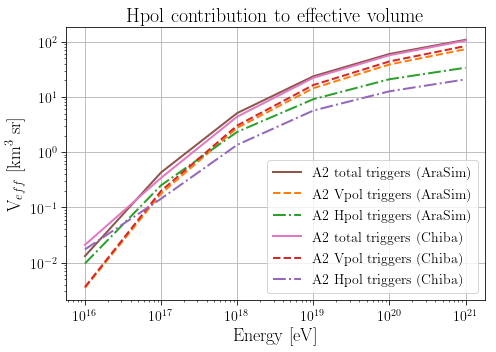

In [25]:
plt.figure(figsize=(7,5))

# plt.plot(default.Energy, default.Veff, label = "A2 All triggers")
# plt.fill_between(default.Energy, default.Veff-default.Err_Veff, default.Veff+default.Err_Veff, alpha=0.5)
# plt.plot(default.Energy, default.VeffVpol, label = "A2 Vpol triggers")
# plt.plot(default.Energy, default.VeffHpol, label = "A2 Hpol triggers")

# plt.plot(Chiba.Energy, Chiba.Veff, label = "A2 All triggers")
# plt.fill_between(Chiba.Energy, Chiba.Veff-Chiba.Err_Veff, Chiba.Veff+Chiba.Err_Veff, alpha=0.5)
# plt.plot(Chiba.Energy, Chiba.VeffVpol, label = "A2 Vpol triggers")
plt.plot(default.Energy, default.Veff, lw=2, color="C5",label = "A2 total triggers (AraSim)")
plt.plot(default.Energy, default.VeffVpol,"--", lw=2, color="C1",label = "A2 Vpol triggers (AraSim)")
plt.plot(default.Energy, default.VeffHpol,"-.", lw=2, color="C2",label = "A2 Hpol triggers (AraSim)")

plt.plot(Chiba.Energy, Chiba.Veff, lw=2, color="C6",label = "A2 total triggers (Chiba)")
plt.plot(Chiba.Energy, Chiba.VeffVpol,"--", lw=2, color="C3",label = "A2 Vpol triggers (Chiba)")
plt.plot(Chiba.Energy, Chiba.VeffHpol,"-.", lw=2, color="C4",label = "A2 Hpol triggers (Chiba)")



plt.yscale('log')
plt.xscale('log')
plt.title("Hpol contribution to effective volume")
plt.xlabel("Energy [eV]")
plt.ylabel("V$_{eff}$ [km$^3$ sr]")
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig("./plots/Antennas/Veff_comparisonChibavsAraSim.pdf")

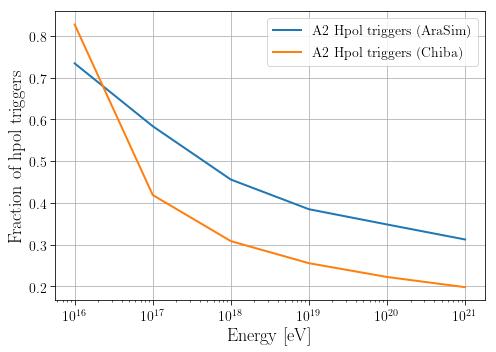

In [30]:
plt.figure(figsize=(7,5))

plt.plot(default.Energy, default.VeffHpol/default.Veff, lw=2, label = "A2 Hpol triggers (AraSim)")
plt.plot(Chiba.Energy, Chiba.VeffHpol/Chiba.Veff, lw=2, label = "A2 Hpol triggers (Chiba)")


plt.xscale('log')
# plt.title("Effective volume for A2 (used in latest A23 paper)")
plt.xlabel("Energy [eV]")
plt.ylabel("Fraction of hpol triggers")
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig("./plots/Antennas/HpolTriggers_ChibavsAraSim.pdf")


In [21]:
default_ = default[['Energy','Veff','VeffVpol','VeffHpol']]
print("AraSim")
default_

AraSim


,Energy,Veff,VeffVpol,VeffHpol
0,1.000000e+16,0.013102,0.003480,0.009622
1,1.000000e+17,0.428985,0.177265,0.250447
2,1.000000e+18,5.100196,2.752339,2.325718
3,1.000000e+19,23.629730,14.387500,9.094459
4,1.000000e+20,59.971600,38.650250,20.891690
5,1.000000e+21,108.209800,73.256580,33.799870


In [20]:
Chiba_ = Chiba[['Energy','Veff','VeffVpol','VeffHpol']]
print("Chiba")
Chiba_

Chiba


,Energy,Veff,VeffVpol,VeffHpol
0,1.000000e+16,0.020914,0.003606,0.017308
1,1.000000e+17,0.342087,0.198371,0.143289
2,1.000000e+18,4.395948,3.029083,1.355778
3,1.000000e+19,22.165040,16.414280,5.662698
4,1.000000e+20,56.843180,43.885900,12.647060
5,1.000000e+21,104.867300,83.395930,20.767420
